In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import InceptionResNetV2

In [ ]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install opencv-python

%pip install tqdm
%pip install sklearn
%pip install keras
%pip install tensorflow


In [ ]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('sarscov2-ctscan-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [36]:
disease_types=['COVID', 'non-COVID']
data_dir = 'sarscov2-ctscan-dataset/'
train_dir = os.path.join(data_dir)

In [37]:
from glob import glob
covid_path = 'sarscov2-ctscan-dataset/COVID'
noncovid_path = 'sarscov2-ctscan-dataset/non-COVID'
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [38]:
print("First 5 Covid Files: ",covid_files[0:5])
print("Total Count: ",len(covid_files))
print("First 5 NonCovid Files: ",noncovid_files[0:5])
print("Total Count: ",len(noncovid_files))

First 5 Covid Files:  ['sarscov2-ctscan-dataset/COVID\\Covid (1).png', 'sarscov2-ctscan-dataset/COVID\\Covid (10).png', 'sarscov2-ctscan-dataset/COVID\\Covid (100).png', 'sarscov2-ctscan-dataset/COVID\\Covid (1000).png', 'sarscov2-ctscan-dataset/COVID\\Covid (1001).png']
Total Count:  1252
First 5 NonCovid Files:  ['sarscov2-ctscan-dataset/non-COVID\\Non-Covid (1).png', 'sarscov2-ctscan-dataset/non-COVID\\Non-Covid (10).png', 'sarscov2-ctscan-dataset/non-COVID\\Non-Covid (100).png', 'sarscov2-ctscan-dataset/non-COVID\\Non-Covid (1000).png', 'sarscov2-ctscan-dataset/non-COVID\\Non-Covid (1001).png']
Total Count:  1229


In [39]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (1).png,0,COVID
1,COVID/Covid (10).png,0,COVID
2,COVID/Covid (100).png,0,COVID
3,COVID/Covid (1000).png,0,COVID
4,COVID/Covid (1001).png,0,COVID


In [ ]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (54).png,0,COVID
1,COVID/Covid (1035).png,0,COVID
2,non-COVID/Non-Covid (21).png,1,non-COVID
3,non-COVID/Non-Covid (248).png,1,non-COVID
4,COVID/Covid (409).png,0,COVID


In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1

In [ ]:
IMAGE_SIZE = 120
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

2481it [00:25, 96.19it/s]


Train Shape: (2481, 120, 120, 3)


In [ ]:
y_train = train['DiseaseID'].values
y_train = to_categorical(y_train, num_classes=2)

In [ ]:
BATCH_SIZE = 256
X_train, X_test, y_train, y_test = train_test_split(X_Train, y_train, test_size=0.2, random_state=SEED)

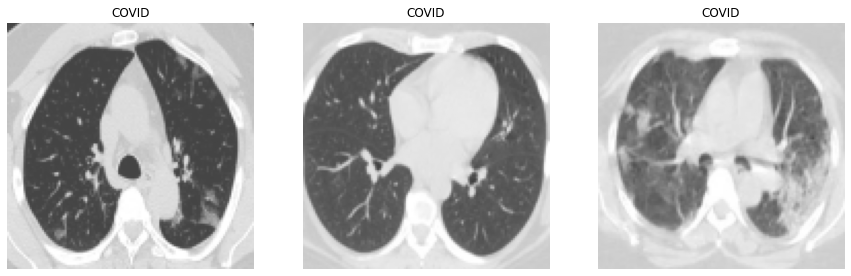

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(y_train[i])])

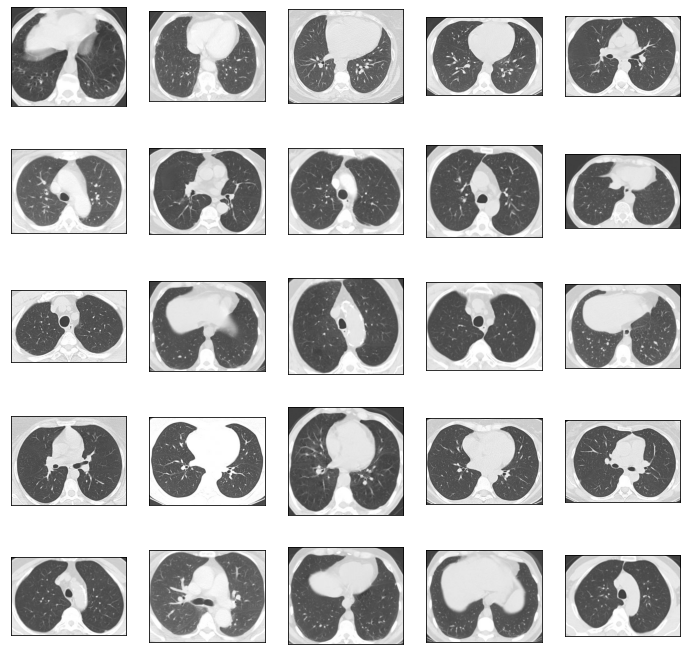

In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('non-COVID', 5, 5)

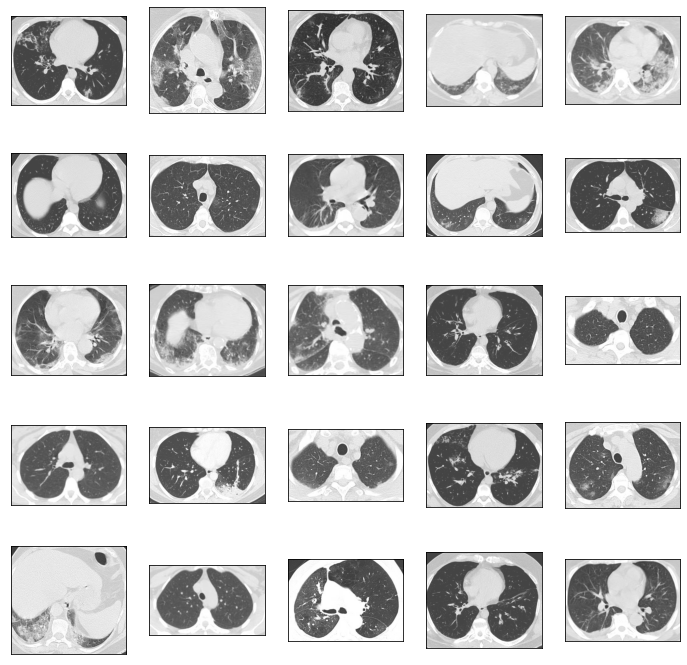

In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1

plot_defects('COVID', 5, 5)

In [ ]:
EPOCHS = 150
SIZE=120
N_ch=3

In [ ]:
def resnet():
    inres = InceptionResNetV2(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = inres(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
model = resnet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('InceptionResNetV2.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(rotation_range=360, 
                        width_shift_range=0.2, 
                        height_shift_range=0.2, 
                        zoom_range=0.2, 
                        horizontal_flip=True,
                        vertical_flip=True) 

datagen.fit(X_train)

hist = model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_test, y_test))

219062272/219055592 [==============================] - 66s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 120, 120, 3)       0         
_________________________________________________________________
conv2d_204 (Conv2D)          (None, 120, 120, 3)       84        
_________________________________________________________________
inception_resnet_v2 (Model)  (None, None, None, 1536)  54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
batch_normalization_204 (Bat (None, 1536)              6144      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________

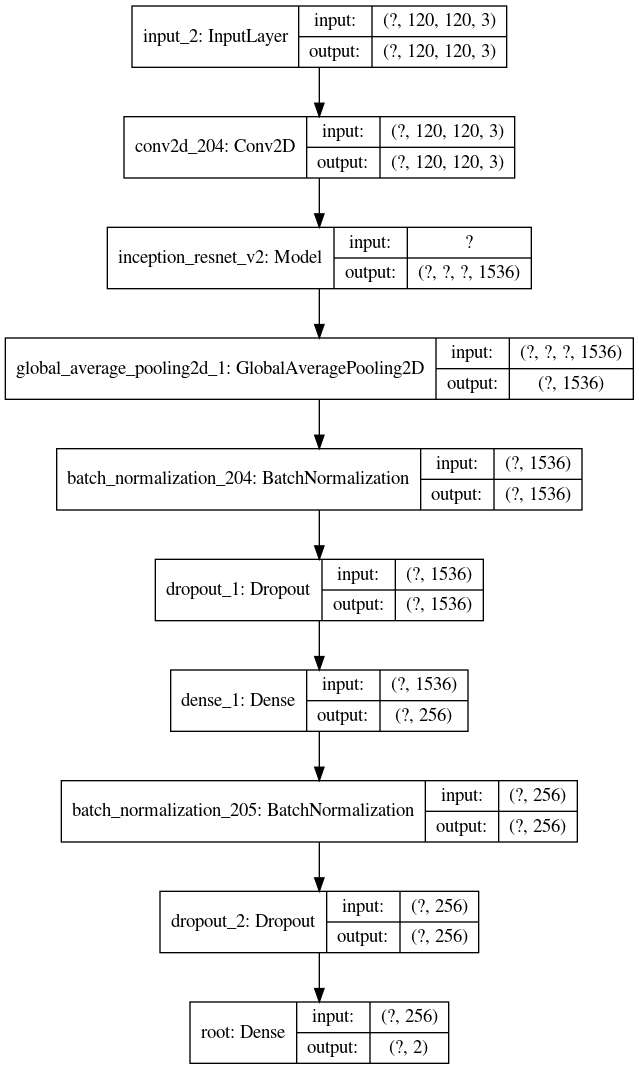

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [ ]:
#model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_test, y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

497/497 [==============================] - 2s 3ms/step
Final Loss: 0.2064932597654926, Final Accuracy: 0.9255533218383789


Text(0.5, 145.31999999999996, 'Predicted')

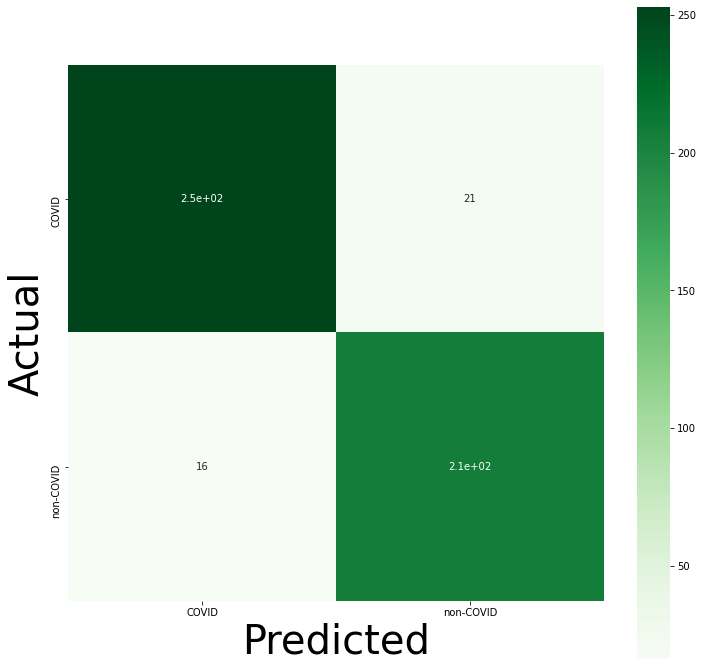

In [ ]:
Y_pred = model.predict(X_test)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

In [ ]:
'''FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.values.sum() - (FP + FN + TP)'''

TN = cm[0][0]
#print(TN)
FN = cm[1][0]
#print(FN)
TP = cm[1][1]
#print(TP)
FP = cm[0][1]
#print(FP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("Sensitivity :",TPR)
# Specificity or true negative rate
TNR = TN/(TN+FP)
print("Specificity :",TNR)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
print("FNR :",FNR)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Accuracy :",ACC)

Sensitivity : 0.9282511210762332
Specificity : 0.9233576642335767
FNR : 0.07174887892376682
Accuracy : 0.9255533199195171


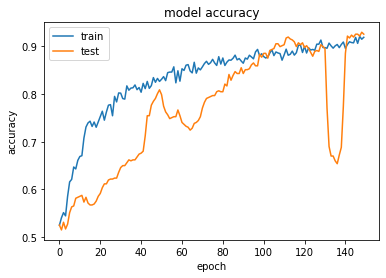

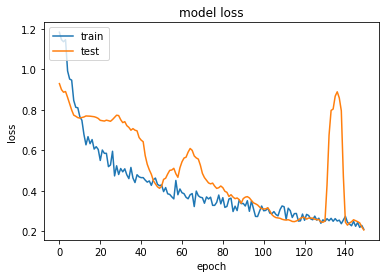

In [ ]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[0.9101657  0.08983427]


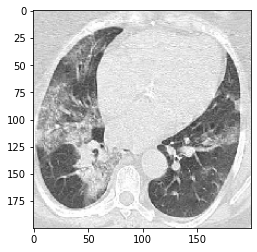

Prediction: Covid-19


In [ ]:
from skimage import io
from keras.preprocessing import image
img = image.load_img('sarscov2-ctscan-dataset/COVID/Covid (1000).png', grayscale=False, target_size=(64, 64))
show_img=image.load_img('sarscov2-ctscan-dataset/COVID/Covid (1000).png', grayscale=False, target_size=(200, 200))
disease_class=['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(X_test)
print(custom[0])

plt.imshow(show_img)
plt.show()
a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])